In [1]:
import tensorflow as tf 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding,LSTM,TimeDistributed,Dense,Flatten,Dropout,RepeatVector,GRU,Bidirectional,Permute
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import kerastuner as kt
from kerastuner.tuners import BayesianOptimization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
from keras_preprocessing import sequence
from tensorflow.python.keras.layers import Concatenate,concatenate,Activation, dot

import os
adam=Adam(lr=0.001)
filename='pre_data_dl.xlsx'
data_dl=pd.read_excel(filename)
pd.set_option('display.max_columns', None)
print(data_dl.head())

filename1='pre_data_dl_aug1.xlsx'
filename2='pre_data_dl_aug2.xlsx'

data_dl_aug1=pd.read_excel(filename1)
pd.set_option('display.max_columns', None)
print(data_dl_aug1.head())

data_dl_aug2=pd.read_excel(filename2)
print(data_dl_aug2.head())

X = (data_dl["Combined Description Cleaned"])
y= (data_dl['Assignment group'])

#categorical encoding y
y=pd.get_dummies(data_dl['Assignment group'])
  

#parameters
max_features=10000
emb_dim=300
batch_size=256
epochs=25
out_dim=74

   Unnamed: 0  Unnamed: 0.1  \
0           0             0   
1           1             1   
2           2             2   
3           3             3   
4           4             4   

                        Combined Description Cleaned Assignment group  
0  login issue user manager name checked the name...            GRP_0  
1  outlook received from hello team my are not in...            GRP_0  
2    cannot log in to received from   cannot on best            GRP_0  
3                         unable to access tool page            GRP_0  
4                                              error            GRP_0  
   Unnamed: 0                       Combined Description Cleaned  \
0           0  login issue user manager name checked the name...   
1           1  outlook received from hello team my are not in...   
2           2  cannot log in to received from hi i cannot on ...   
3           3                         unable to access tool page   
4           4                            

In [2]:
#function for tokenizer
def dfTokenizer(df):
 tokenizer=Tokenizer(num_words=max_features,char_level=False)
 tokenizer.fit_on_texts(df)
 sequences=tokenizer.texts_to_sequences(df)
 return sequences,tokenizer
#tokenization
X,tokenizer = dfTokenizer(data_dl["Combined Description Cleaned"]) 
vocab_size=len(tokenizer.word_index)
print("vocabulary size is: ",vocab_size)

#function for padding
def pad(x, length=None):
 if length is None:
   length=max([len(sentence)  for sentence in x])
 return pad_sequences(x,maxlen=length,padding='post')
 
 #padding 
X=pad_sequences(X,padding='post')


#function for splitting the data
def split(X,y):
 X_train_spl,X_test_spl,y_train_spl,y_test_spl=train_test_split(X,y,test_size=0.3,random_state=123)
 return X_train_spl,X_test_spl,y_train_spl,y_test_spl
#split the data
X_train,X_test,y_train,y_test=split(X,y)


#configuring the callback
early_stopping =  EarlyStopping(
    monitor='val_accuracy', 
    patience=3, 
    min_delta=0.001, 
    mode='max'
)


#function for plotting accuracy,loss
def plot(model,history):
 acc = history.history['accuracy']
 val_acc = history.history['val_accuracy']
 loss = history.history['loss']
 val_loss = history.history['val_loss']
 epochs = range(1, len(acc) + 1)
 plt.plot(epochs, acc, 'bo', label='Training acc')
 plt.plot(epochs, val_acc, 'b', label='Validation acc')
 plt.title( ' Training and validation accuracy')
 plt.legend()
 plt.figure()
 plt.plot(epochs, loss, 'bo', label='Training loss')
 plt.plot(epochs, val_loss, 'b', label='Validation loss')
 plt.title('Training and validation loss')
 plt.legend()
 plt.show()
 return 

vocabulary size is:  3316


In [3]:
# create attention layer
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [4]:
inp_len=X.shape[1]
inputs = Input(shape=(inp_len,))
#attention with encoder only
sequence_input = Input(shape=(inp_len), dtype='int32')        
embedded_sequences =Embedding(max_features,emb_dim,input_length=inp_len)(sequence_input)     
BILSTM= Bidirectional(LSTM(128, return_sequences=True,dropout=0.2,name="bi_lstm_0",return_state=True))(embedded_sequences)
#rp=RepeatVector(max_features)(lstm)

#xy = tf.reshape(lstm, [189, 256])
#rp=RepeatVector(max_features)(xy)

BILSTM,forward_h, forward_c, backward_h, backward_c= Bidirectional \
                                                    (LSTM
                                                    (128,
                                                     dropout=0.2,
                                                     return_state=True,
                                                    
                                                     return_sequences=True))(BILSTM)
                                                   
                                                   
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

context_vector,attention_weights = Attention(128)(BILSTM,state_h)
fl=Flatten()(context_vector)
output = Dense(74, activation='sigmoid')(fl)

model_att =tf.keras.Model(inputs=sequence_input, outputs=output)

# summarize layers
print(model_att.summary())


#Attention with encoder decoder
inp = Embedding(max_features,emb_dim,input_length=inp_len)(inputs)
lstm_out = LSTM(64, return_sequences=True)(inp)

attention = Dense(1, activation='relu')(lstm_out)
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(64)(attention)
#attention = LSTM(64,return_sequences=False)(attention)
attention = Permute([2,1])(attention)

combined = concatenate([lstm_out, attention])
combined_mul = Flatten()(combined)
decode = RepeatVector(64)(combined_mul)

decode = LSTM(64, return_sequences=True)(decode)
decode=Flatten()(decode)
decode = (Dense(74))(decode)

decode = Activation('softmax')(decode)

model_enc_dec_att = tf.keras.Model(inputs=inputs, outputs=decode)

#model= tf.keras.Model(inputs=[encoder_inputs, decoder_inputs], outputs=[output])
model_enc_dec_att.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
print(model_enc_dec_att.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 189)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 189, 300)     3000000     input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 189, 256), ( 439296      embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 189, 256), ( 394240      bidirectional[0][0]              
                                                                 bidirectional[0][1]   

In [5]:
def ENC_ATT_model(hp): #attention with encoder
 model = model_att
 print(model.summary())
 lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])   
 model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
 
 return model

def ENC_DEC_ATT_model(hp):#attention with encoder decoder
 model = model_enc_dec_att
 print(model.summary())
 lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])   
 model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
 
 return model

In [6]:
class MyTuner(kt.tuners.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
     kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 64, 128,step=64 )
    # kwargs['epochs'] = trial.hyperparameters.Int('epochs', 5, 10,20)
     super(MyTuner, self).run_trial(trial, *args, **kwargs)

INFO:tensorflow:Reloading Oracle from existing project C:/Hyperparameter/35F\untitled_project\oracle.json
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 189)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 189, 300)     3000000     input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 189, 256), ( 439296      embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 189, 256), ( 394240      bidirectional[0

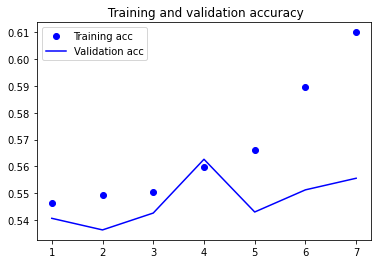

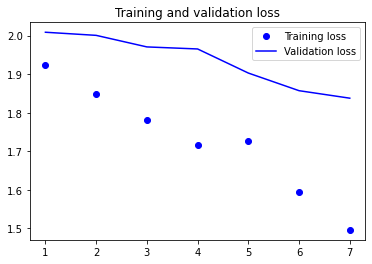

In [7]:
tuner =MyTuner(
    ENC_ATT_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/35F"
)

tuner.search(X_train,y_train,validation_data=(X_test,y_test))
print(tuner.results_summary(5))
best_model_ENC_ATT = tuner.get_best_models()[0]
print("Hyperparameters for ENC_ATT are",best_model_ENC_ATT)


modelname="ENC_ATTModel"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
#epochs_hyp=list(vals.values())[2]
history=best_model_ENC_ATT.fit(X_train,y_train,batch_size=batch_size_hyp,epochs=epochs,validation_data=(X_test,y_test),callbacks=[early_stopping])
plot(best_model_ENC_ATT,history)

In [9]:
#scores_ENC_ATT =best_model_ENC_ATT.evaluate(X_test, y_test, verbose=0)
#scores_ENC_ATT_val = best_model_ENC_ATT.evaluate(X_train, y_train, verbose=0)
print("Accuracy of ENC_ATT for unaugmented data is :",np.array(history.history['val_accuracy']).mean()*100)
#print("Validation Accuracy of ENC_ATT for unagumented data is:", (scores_ENC_ATT_val[1]*100))
print("Training Accuracy of ENC_ATT for unagumented data is:" ,np.array(history.history['accuracy']).mean()*100)
print( "Mean loss of  Validation data of ENC_ATT for unaugmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  Training data of ENC_ATT for unaugmented data is :",np.array(history.history['loss'])
      .mean())

Accuracy of ENC_ATT for unaugmented data is : 54.746001107352114
Training Accuracy of ENC_ATT for unagumented data is: 56.73373086111886
Mean loss of  Validation data of ENC_ATT for unaugmented data is : 1.9346729687282018
Mean loss of  Training data of ENC_ATT for unaugmented data is : 1.7268002544130598


In [10]:
#x
      

INFO:tensorflow:Reloading Oracle from existing project C:/Hyperparameter/31G\untitled_project\oracle.json
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 189)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 189, 300)     3000000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 189, 64)      93440       embedding_1[0][0]                
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 189, 1)       65          lstm_1[0][0]   

93/93 [==============================] - 357s 4s/step - loss: 1.3036 - accuracy: 0.6370 - val_loss: 1.8827 - val_accuracy: 0.5910
Epoch 2/25
93/93 [==============================] - 273s 3s/step - loss: 1.1466 - accuracy: 0.6656 - val_loss: 2.0246 - val_accuracy: 0.5764
Epoch 3/25
93/93 [==============================] - 269s 3s/step - loss: 1.0264 - accuracy: 0.6920 - val_loss: 2.0648 - val_accuracy: 0.5784
Epoch 4/25
93/93 [==============================] - 267s 3s/step - loss: 0.8964 - accuracy: 0.7342 - val_loss: 2.1752 - val_accuracy: 0.5776


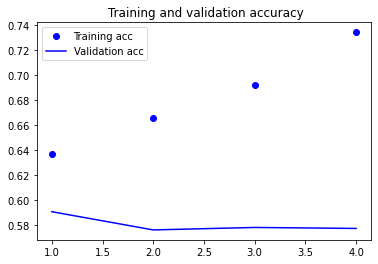

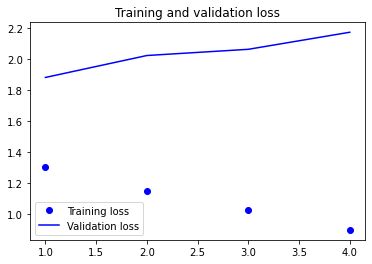

In [11]:
tuner =MyTuner(
    ENC_DEC_ATT_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/31G"
)

tuner.search(X_train,y_train,validation_data=(X_test,y_test))
print(tuner.results_summary(5))
best_model_ENC_DEC_ATT = tuner.get_best_models()[0]
print("Hyperparameters for ENC_DEC_ATT are",best_model_ENC_DEC_ATT)


modelname="ENC_DEC_ATTModel"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
#epochs_hyp=list(vals.values())[2]
history=best_model_ENC_DEC_ATT.fit(X_train,y_train,batch_size=batch_size_hyp,epochs=epochs,validation_data=(X_test,y_test),callbacks=[early_stopping])
plot(best_model_ENC_DEC_ATT,history)

In [12]:
#scores_ENC_DEC_ATT =best_model_ENC_DEC_ATT.evaluate(X_test, y_test, verbose=0)
#scores_ENC_DEC_ATT_val = best_model_ENC_DEC_ATT.evaluate(X_train, y_train, verbose=0)
print("Accuracy of ENC_DEC_ATT for unaugmented data is :", np.array(history.history['val_accuracy']).mean()*100)
#print("Validation Accuracy of ENC_DEC_ATT for unagumented data is:", (scores_ENC_DEC_ATT_val[1]*100))
print("Training Accuracy of ENC_DEC_ATT for unagumented data is:" ,np.array(history.history['accuracy']).mean()*100)
print( "Mean loss of  Validation data of ENC_DEC_ATT for unaugmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  Training data of ENC_DEC_ATT for unaugmented data is :",np.array(history.history['loss']).mean())    

Accuracy of ENC_DEC_ATT for unaugmented data is : 58.084478974342346
Training Accuracy of ENC_DEC_ATT for unagumented data is: 68.21933835744858
Mean loss of  Validation data of ENC_DEC_ATT for unaugmented data is : 2.036827176809311
Mean loss of  Training data of ENC_DEC_ATT for unaugmented data is : 1.0932626575231552


In [13]:
X_aug1 = (data_dl_aug1["Combined Description Cleaned"])
y_aug1= (data_dl_aug1['Assignment group'])

#categorical encoding y
y_aug1=pd.get_dummies(data_dl_aug2['Assignment group'])


X_aug2 = (data_dl_aug2["Combined Description Cleaned"])
y_aug2= (data_dl_aug2['Assignment group'])

#categorical encoding y
y_aug2=pd.get_dummies(data_dl_aug2['Assignment group'])

#tokenization
X_aug1,tokenizer = dfTokenizer(data_dl_aug1["Combined Description Cleaned"]) 
vocab_size_aug1=len(tokenizer.word_index)
print("vocabulary size is: ",vocab_size_aug1)

X_aug2,tokenizer = dfTokenizer(data_dl_aug2["Combined Description Cleaned"]) 
vocab_size_aug2=len(tokenizer.word_index)
print("vocabulary size is: ",vocab_size_aug2)

#padding
X_aug1=pad_sequences(X_aug1,padding='post')
X_aug2=pad_sequences(X_aug2,padding='post')
y_aug1=y_aug1[0:17586]

def split_stratify(X,y):
 X_train_spl,X_test_spl,y_train_spl,y_test_spl=train_test_split(X,y,test_size=0.3,stratify=y,random_state=123)
 return X_train_spl,X_test_spl,y_train_spl,y_test_spl

X_train_aug1,X_test_aug1,y_train_aug1,y_test_aug1=split_stratify(X_aug1,y_aug1)
X_train_aug2,X_test_aug2,y_train_aug2,y_test_aug2=split_stratify(X_aug2,y_aug2)


inp_len1=X_aug1.shape[1]
print(inp_len1)

vocabulary size is:  3956
vocabulary size is:  4424
191


In [14]:
#x

In [15]:
 
#attention with encoder only

sequence_input = Input(shape=(inp_len1), dtype='int32')        
embedded_sequences =Embedding(max_features,emb_dim,input_length=inp_len1)(sequence_input)     
BILSTM= Bidirectional(LSTM(128, return_sequences=True,dropout=0.2,name="bi_lstm_0",return_state=True))(embedded_sequences)
#rp=RepeatVector(max_features)(lstm)

#xy = tf.reshape(lstm, [189, 256])
#rp=RepeatVector(max_features)(xy)

BILSTM,forward_h, forward_c, backward_h, backward_c= Bidirectional \
                                                    (LSTM
                                                    (128,
                                                     dropout=0.2,
                                                     return_state=True,
                                                    
                                                     return_sequences=True))(BILSTM)
                                                   
                                                   
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

context_vector,attention_weights = Attention(32)(BILSTM,state_h)
fl=Flatten()(context_vector)
output = Dense(74, activation='sigmoid')(fl)

model_att1 =tf.keras.Model(inputs=sequence_input, outputs=output)

# summarize layers
print(model_att1.summary())


#Attention with encoder decoder
inp = Embedding(max_features,emb_dim,input_length=inp_len1)(sequence_input)
lstm_out = LSTM(64, return_sequences=True)(inp)

attention = Dense(1, activation='relu')(lstm_out)
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(64)(attention)
#attention = LSTM(64,return_sequences=False)(attention)
attention = Permute([2,1])(attention)

combined = concatenate([lstm_out, attention])
combined_mul = Flatten()(combined)
decode = RepeatVector(64)(combined_mul)

decode = LSTM(64, return_sequences=True)(decode)
decode=Flatten()(decode)
decode = (Dense(74))(decode)

decode = Activation('softmax')(decode)

model_enc_dec_att1 = tf.keras.Model(inputs=sequence_input, outputs=decode)

#model= tf.keras.Model(inputs=[encoder_inputs, decoder_inputs], outputs=[output])
model_enc_dec_att1.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
print(model_enc_dec_att1.summary())

def ENC_ATT_model1(hp): #attention with encoder
 model = model_att1
 print(model.summary())
 lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])   
 model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
 
 return model

def ENC_DEC_ATT_model1(hp):#attention with encoder decoder
 model = model_enc_dec_att1
 print(model.summary())
 lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])   
 model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
 
 return model

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 191)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 191, 300)     3000000     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 191, 256), ( 439296      embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 191, 256), ( 394240      bidirectional[0][0]              
                                                                 bidirectional[0][1]   

INFO:tensorflow:Reloading Oracle from existing project C:/Hyperparameter/30A\untitled_project\oracle.json
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 191)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 191, 300)     3000000     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 191, 256), ( 439296      embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 191, 256), ( 394240      bidirectional[0

Epoch 14/25
97/97 [==============================] - 423s 4s/step - loss: 0.3620 - accuracy: 0.8883 - val_loss: 0.8997 - val_accuracy: 0.7629
Epoch 15/25
97/97 [==============================] - 419s 4s/step - loss: 0.3368 - accuracy: 0.8984 - val_loss: 0.9102 - val_accuracy: 0.7618
Epoch 16/25
97/97 [==============================] - 440s 5s/step - loss: 0.3147 - accuracy: 0.9036 - val_loss: 0.8500 - val_accuracy: 0.7769
Epoch 17/25
97/97 [==============================] - 460s 5s/step - loss: 0.2768 - accuracy: 0.9147 - val_loss: 0.8534 - val_accuracy: 0.7811
Epoch 18/25
97/97 [==============================] - 461s 5s/step - loss: 0.2515 - accuracy: 0.9234 - val_loss: 0.8859 - val_accuracy: 0.7834
Epoch 19/25
97/97 [==============================] - 460s 5s/step - loss: 0.2474 - accuracy: 0.9232 - val_loss: 0.8519 - val_accuracy: 0.7858
Epoch 20/25
97/97 [==============================] - 461s 5s/step - loss: 0.2298 - accuracy: 0.9280 - val_loss: 0.8308 - val_accuracy: 0.7868
Epoch 

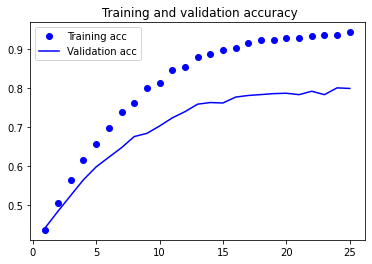

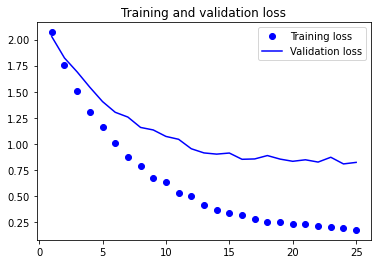

In [16]:
tuner =MyTuner(
    ENC_ATT_model1,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/30A"
)

tuner.search(X_train_aug1,y_train_aug1,validation_data=(X_test_aug1,y_test_aug1))
print(tuner.results_summary(5))
best_model_ENC_ATT = tuner.get_best_models()[0]
print("Hyperparameters for ENC_ATT are",best_model_ENC_ATT)


modelname="ENC_ATTModel_aug1"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
#epochs_hyp=list(vals.values())[2]
history=best_model_ENC_ATT.fit(X_train_aug1,y_train_aug1,batch_size=batch_size_hyp,epochs=epochs,validation_data=(X_test_aug1,y_test_aug1),callbacks=[early_stopping])
plot(best_model_ENC_ATT,history)

In [17]:
#scores_ENC_ATT_aug1 =best_model_ENC_ATT.evaluate(X_test_aug1, y_test_aug1, verbose=0)
#scores_ENC_ATT_val_aug1 = best_model_ENC_ATT.evaluate(X_train_aug1, y_train_aug1, verbose=0)
print("Accuracy of ENC_ATT for level1 augmented data is :",np.array(history.history['val_accuracy']).mean()*100)
#print("Validation Accuracy of ENC_ATT for level1 augmented data is:", (scores_ENC_ATT_val_aug1[1]*100))
print("Training Accuracy of ENC_ATT for level1 augmented data is:" ,np.array(history.history['accuracy']).mean()*100)
print( "Mean loss of  Validation data of ENC_ATT for level1 augmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  training data of ENC_ATT for level1 augmented data is :",np.array(history.history['loss']).mean())

Accuracy of ENC_ATT for level1 augmented data is : 70.24791610240936
Training Accuracy of ENC_ATT for level1 augmented data is: 80.91990292072296
Mean loss of  Validation data of ENC_ATT for level1 augmented data is : 1.1022715091705322
Mean loss of  training data of ENC_ATT for level1 augmented data is : 0.6482395780086517


Trial 5 Complete [00h 23m 41s]
val_accuracy: 0.8586527109146118

Best val_accuracy So Far: 0.8586527109146118
Total elapsed time: 01h 35m 32s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in C:/Hyperparameter/12F\untitled_project
Showing 5 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 64
Score: 0.8586527109146118
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 128
Score: 0.8425322771072388
Trial summary
Hyperparameters:
learning_rate: 0.0001
batch_size: 64
Score: 0.7744208574295044
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 128
Score: 0.6876267790794373
Trial summary
Hyperparameters:
learning_rate: 0.01
batch_size: 64
Score: 0.4997331202030182
None
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to              

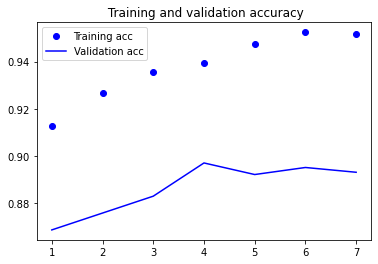

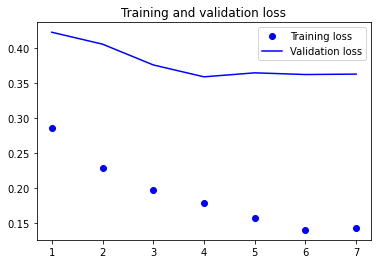

In [18]:
tuner =MyTuner(
    ENC_ATT_model1,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/12F"
)

tuner.search(X_train_aug2,y_train_aug2,validation_data=(X_test_aug2,y_test_aug2))
print(tuner.results_summary(5))
best_model_ENC_ATT = tuner.get_best_models()[0]
print("Hyperparameters for ENC_ATT are",best_model_ENC_ATT)


modelname="ENC_ATTModel_aug2"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
#epochs_hyp=list(vals.values())[2]
history=best_model_ENC_ATT.fit(X_train_aug2,y_train_aug2,batch_size=batch_size_hyp,epochs=epochs,validation_data=(X_test_aug2,y_test_aug2),callbacks=[early_stopping])
plot(best_model_ENC_ATT,history)

In [19]:
scores_ENC_ATT_aug2 =best_model_ENC_ATT.evaluate(X_test_aug2, y_test_aug2, verbose=0)
#scores_ENC_ATT_val_aug2 = best_model_ENC_ATT.evaluate(X_train_aug2, y_train_aug2, verbose=0)
print("Accuracy of ENC_ATT for level2 augmented data is :", np.array(history.history['val_accuracy']).mean()*100)
#print("Validation Accuracy of ENC_ATT for level2 augmented data is:", (scores_ENC_ATT_val_aug2[1]*100))
print("Training Accuracy of ENC_ATT for level2 augmented data is:" ,np.array(history.history['accuracy']).mean()*100)
print( "Mean loss of  Validation data of ENC_ATT for level2 augmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  training data of ENC_ATT for level2 augmented data is :",np.array(history.history['loss']).mean())

Accuracy of ENC_ATT for level2 augmented data is : 88.63334826060704
Training Accuracy of ENC_ATT for level2 augmented data is: 93.78995639937264
Mean loss of  Validation data of ENC_ATT for level2 augmented data is : 0.37882390192576815
Mean loss of  training data of ENC_ATT for level2 augmented data is : 0.19046684035233089


In [20]:
#x

Trial 5 Complete [00h 13m 55s]
val_accuracy: 0.7714177370071411

Best val_accuracy So Far: 0.7714177370071411
Total elapsed time: 01h 26m 07s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in C:/Hyperparameter/12M\untitled_project
Showing 5 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 64
Score: 0.7714177370071411
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 128
Score: 0.7384381890296936
Trial summary
Hyperparameters:
learning_rate: 0.0001
batch_size: 64
Score: 0.7158832550048828
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 128
Score: 0.6161864995956421
Trial summary
Hyperparameters:
learning_rate: 0.01
batch_size: 64
Score: 0.42039424180984497
None
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to             

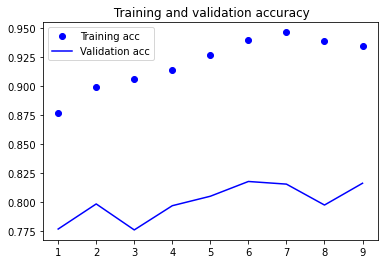

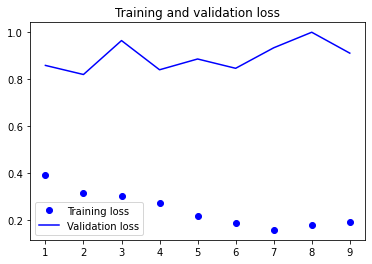

In [21]:
tuner =MyTuner(
    ENC_DEC_ATT_model1,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/12M"
)

tuner.search(X_train_aug1,y_train_aug1,validation_data=(X_test_aug1,y_test_aug1))
print(tuner.results_summary(5))
best_model_ENC_DEC_ATT = tuner.get_best_models()[0]
print("Hyperparameters for ENC_DEC_ATT are",best_model_ENC_DEC_ATT)


modelname="ENC_DEC_ATTModel_aug1"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
#epochs_hyp=list(vals.values())[2]
history=best_model_ENC_DEC_ATT.fit(X_train_aug1,y_train_aug1,batch_size=batch_size_hyp,epochs=epochs,validation_data=(X_test_aug1,y_test_aug1),callbacks=[early_stopping])
plot(best_model_ENC_DEC_ATT,history)

In [22]:
scores_ENC_DEC_ATT_aug1 =best_model_ENC_DEC_ATT.evaluate(X_test_aug1, y_test_aug1, verbose=0)
#scores_ENC_DEC_ATT_val_aug1 = best_model_ENC_DEC_ATT.evaluate(X_train_aug1, y_train_aug1, verbose=0)
print("Accuracy of ENC_DEC_ATT for level1 augmented data is :", np.array(history.history['val_accuracy']).mean()*100)
#print("Validation Accuracy of ENC_DEC_ATT for level1 augmented data is:", (scores_ENC_DEC_ATT_val_aug1[1]*100))
print("Training Accuracy of ENC_DEC_ATT for level1 augmented data is:" ,np.array(history.history['accuracy']).mean()*100)
print( "Mean loss of  Validation data of ENC_DEC_ATT for level1 augmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  training data of ENC_DEC_ATT for level1 augmented data is :",np.array(history.history['loss']).mean())

Accuracy of ENC_DEC_ATT for level1 augmented data is : 79.99326123131645
Training Accuracy of ENC_DEC_ATT for level1 augmented data is: 92.00830393367343
Mean loss of  Validation data of ENC_DEC_ATT for level1 augmented data is : 0.8944875200589498
Mean loss of  training data of ENC_DEC_ATT for level1 augmented data is : 0.24763991600937313


Trial 5 Complete [00h 21m 25s]
val_accuracy: 0.8850218653678894

Best val_accuracy So Far: 0.901996374130249
Total elapsed time: 02h 39m 13s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in C:/Hyperparameter/14H\untitled_project
Showing 5 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 128
Score: 0.901996374130249
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 64
Score: 0.8850218653678894
Trial summary
Hyperparameters:
learning_rate: 0.0001
batch_size: 64
Score: 0.870823085308075
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 128
Score: 0.8524607419967651
Trial summary
Hyperparameters:
learning_rate: 0.01
batch_size: 64
Score: 0.708551287651062
None
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                  

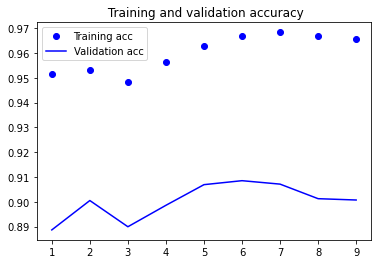

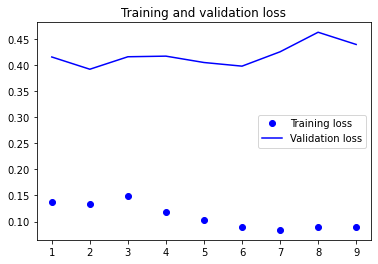

In [23]:
tuner =MyTuner(
    ENC_DEC_ATT_model1,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/14H"
)

tuner.search(X_train_aug2,y_train_aug2,validation_data=(X_test_aug2,y_test_aug2))
print(tuner.results_summary(5))
best_model_ENC_DEC_ATT = tuner.get_best_models()[0]
print("Hyperparameters for ENC_DEC_ATT are",best_model_ENC_DEC_ATT)


modelname="ENC_DEC_ATTModel_aug2"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
#epochs_hyp=list(vals.values())[2]
history=best_model_ENC_DEC_ATT.fit(X_train_aug2,y_train_aug2,batch_size=batch_size_hyp,epochs=epochs,validation_data=(X_test_aug2,y_test_aug2),callbacks=[early_stopping])
plot(best_model_ENC_DEC_ATT,history)

In [24]:
#scores_ENC_DEC_ATT_aug2 =best_model_ENC_DEC_ATT.evaluate(X_test_aug2, y_test_aug2, verbose=0)
#scores_ENC_DEC_ATT_val_aug2 = best_model_ENC_DEC_ATT.evaluate(X_train_aug2, y_train_aug2, verbose=0)
print("Accuracy of ENC_DEC_ATT for level2 augmented data is :", np.array(history.history['val_accuracy']).mean()*100)
#print("Validation Accuracy of ENC_DEC_ATT for level2 augmented data is:", (scores_ENC_DEC_ATT_val_aug2[1]*100))
print("Training Accuracy of ENC_DEC_ATT for level2 augmented data is:" ,np.array(history.history['accuracy']).mean()*100)
print( "Mean loss of  Validation data of ENC_DEC_ATT for level2 augmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  training data of ENC_DEC_ATT for level2 augmented data is :",np.array(history.history['loss']).mean())

Accuracy of ENC_DEC_ATT for level2 augmented data is : 90.02408054139879
Training Accuracy of ENC_DEC_ATT for level2 augmented data is: 96.00124027993944
Mean loss of  Validation data of ENC_DEC_ATT for level2 augmented data is : 0.4186609751648373
Mean loss of  training data of ENC_DEC_ATT for level2 augmented data is : 0.11055167267719905
